In [1]:
import numpy as np
from scipy import stats
from scipy.special import factorial
from epsie import Parameter
from epsie import proposals 
from epsie import samplers

from corner import corner
import matplotlib.pyplot as plt

from multiprocessing import Pool

In [2]:
class TruncatedPoisson(object):
    def __init__(self, mu, bounds):
        self._mu = None
        self._bounds = None
        
        self.bounds = bounds
        self.mu = mu
        
        self._poisson_dist = stats.poisson(self.mu)
        
    @property
    def bounds(self):
        return self._bounds
    
    @bounds.setter
    def bounds(self, bounds):
        if not isinstance(bounds, tuple):
            raise ValueError('please provide a tuple')
        elif not len(bounds) == 2:
            raise ValueError('bounds len must be 2')
        self._bounds = bounds
    
    @property
    def mu(self):
        """Mean of the Poisson distribution"""
        return self._mu
    
    @mu.setter
    def mu(self, mu):
        if not isinstance(mu, (float, int)):
            raise ValueError('provide a valid mean')
        elif not self.bounds[0] <= mu <= self.bounds[1]:
            raise ValueError('mu must be within the bounds')
        self._mu = mu
        
    def rvs(self, size=1):
        newpt = self._poisson_dist.rvs(size)
        cond = (np.logical_and(self._bounds[0] <= newpt, newpt <= self._bounds[1]))
        if np.alltrue(cond):
            return newpt
        else:
            while True:
                mask = np.where(cond == False)
                newpt[mask] = self._poisson_dist.rvs(size=mask[0].size)

                cond = (np.logical_and(self._bounds[0] <= newpt, newpt <= self._bounds[1]))
                if np.alltrue(cond):
                    break
        return newpt
    
    def logpmf(self, points):
        points = np.array(points)
        return (points) * np.log(self._mu) - np.log(factorial(points))      

In [3]:
class Model(object):
    def __init__(self):
        # Set up component-wise parameters
        
        f = Parameter('f', (0.0, np.pi))
        A = Parameter('A', (0, 2.0))
        k = Parameter('k', (1, 4), discrete=True)
        
        self.model_pars = [f, A]
        self.model_ind = k
        
        # Define the injected signal
        self.true_signal = {'f1': np.array([0.44 * np.pi]),
                            'f2': np.array([0.67*np.pi]),
                            'f3': np.array([0.87*np.pi]),
                            'A1': np.array([1]),
                            'A2': np.array([0.5]),
                            'A3': np.array([1]),
                            'k': np.array([3]),
                           }
        
        npoints = 2001
        self.t = np.linspace(0.0, 8*np.pi, npoints)
        
        self.noise_variance = 0.4
        self.ysignal = self.reconstruct_signal(**self.true_signal)\
                        + np.random.normal(loc=0.0, scale=np.sqrt(self.noise_variance),\
                                                                  size=npoints)
        
        # we'll just use a uniform prior on f and A and Poisson prior on k
        mu = 2
        self.prior_dist = {'f' : stats.uniform(f.min, f.width),
                           'A' : stats.uniform(A.min, A.width),
                           'k' : TruncatedPoisson(mu, k.bounds)
                          }
        
    
    
    def prior_rvs(self, size=1):
        kmax = self.model_ind.max
        shape = (size, )
        while True:
            k = self.prior_dist['k'].rvs(size=size)
            sample = dict()
            # Get within model samples
            for p in self.model_pars:
                for i in range(1, kmax+1):
                    par = '{}{}'.format(p.name, i)
                    newpt = np.full(shape, fill_value=np.nan)
                    for j in range(size):
                        if i <= k[j]:
                            newpt[j] = float(self.prior_dist[p.name].rvs())
                    sample[par] = newpt
            sample[self.model_ind.name] = np.array(k)
#             print(self.logprior(**sample))
            if np.isfinite(self.logprior(**sample)):
                break
        return sample
    
    def logprior(self, **kwargs):
        # Prior will need to start dealing with label switching
        kmax = self.model_ind.max
        lp = 0.0
        # Do within model log prior
        for p in self.model_pars:
            point = np.array([[kwargs.get('{}{}'.format(p.name, i))] for i in range(1, kmax+1)]).reshape(-1,)
            mask = np.where(np.isfinite(point))
            if p.discrete:
                lp += sum(self.prior_dist[p.name].logpmf(point[mask]))
            else:
                lp += sum(self.prior_dist[p.name].logpdf(point[mask]))
        # Prior on the model index
        lp += sum(self.prior_dist[self.model_ind.name].logpmf([kwargs[self.model_ind.name]]))
        return lp
    
    def reconstruct_signal(self, **kwargs):
        kmax = int(kwargs['k'])
#         kmax = self.model_ind.max
        y = np.zeros_like(self.t)
        for i in range(1, kmax + 1):
            pars = dict()
            for p in [p.name for p in self.model_pars]:
                pars['{}'.format(p)] = kwargs['{}{}'.format(p, i)]
            y += pars['A'] * np.sin(pars['f'] * self.t)
        return y

    
    def loglikelihood(self, **kwargs):
        d = self.ysignal - self.reconstruct_signal(**kwargs)
        return - 0.5 * np.dot(d, d) / self.noise_variance

    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -np.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [4]:
model = Model()
# np.random.seed(41232319)
np.random.seed(41232319)
point = model.prior_rvs(size=1)

(model.logprior(**point), model.loglikelihood(**point), point)

(array([-5.22594913]),
 -6404.469441555354,
 {'f1': array([0.10632463]),
  'f2': array([2.75587781]),
  'f3': array([2.55469229]),
  'f4': array([nan]),
  'A1': array([1.09385412]),
  'A2': array([0.58591207]),
  'A3': array([1.08952902]),
  'A4': array([nan]),
  'k': array([3])})

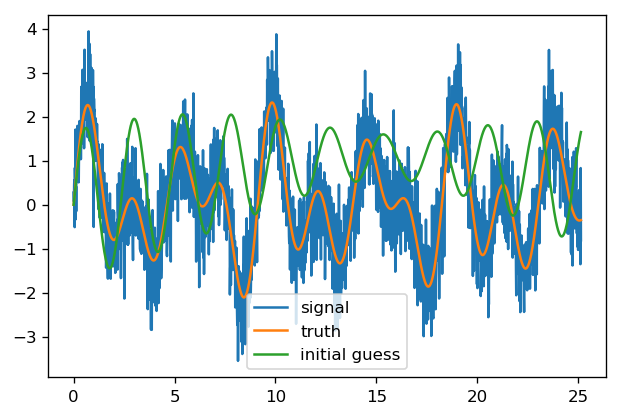

In [5]:
plt.figure(dpi=120)
plt.plot(model.t, model.ysignal, label='signal')
plt.plot(model.t, model.reconstruct_signal(**model.true_signal), label='truth')
plt.plot(model.t, model.reconstruct_signal(**point), label='initial guess')
plt.legend()
plt.show()

## Test: Normal + Poisson proposals

In [6]:
import numpy as np
import epsie.proposals as proposals

In [7]:
all_model_pars = list()
for k in range(model.model_ind.min, model.model_ind.max + 1):
    for p in model.model_pars:
        all_model_pars.append('{}{}'.format(p.name, k))




normal = proposals.Normal(all_model_pars, None)
poisson = proposals.Poisson([model.model_ind.name], [4])
nchains = 1


sampler = samplers.MetropolisHastingsSampler(all_model_pars + [model.model_ind.name],
                                             model, nchains, proposals=[normal, poisson])

sampler.start_position = point

sampler.run(3)

sampler.positions

/home/richard.stiskalek/epsie/epsie/proposals/base.py:97: FutureWarning: Generator is deprecated and will be removed sometime after the release of
NumPy 1.21 (or 2 releases after 1.19 if there is a major release).

Unique features of Generator have been moved to
randomgen.generator.ExtendedGenerator. 

Now is the time to start using numpy.random.Generator.

In the mean time Generator will only be updated for the most egregious bugs.

You can silence this warning using 

import warnings
warnings.filterwarnings("ignore", "Generator", FutureWarning)

  return RandomGenerator(self.bit_generator)
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


array([[(0.10632463, 1.09385412, 2.75587781, 0.58591207, 2.55469229, 1.08952902, nan, nan, 3),
        (0.10632463, 1.09385412, 2.75587781, 0.58591207, 2.55469229, 1.08952902, nan, nan, 3),
        (0.10632463, 1.09385412, 2.75587781, 0.58591207, 2.55469229, 1.08952902, nan, nan, 3)]],
      dtype=[('f1', '<f8'), ('A1', '<f8'), ('f2', '<f8'), ('A2', '<f8'), ('f3', '<f8'), ('A3', '<f8'), ('f4', '<f8'), ('A4', '<f8'), ('k', '<i8')])

## Test: BirthDeath Proposal

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
for p in list(point.keys()):
    if p == 'k':
        point[p] = int(point[p])
    else:
        point[p] = float(point[p])

In [10]:
model_pars = [p.name for p in model.model_pars]
model.model_ind.name

birthdeath = proposals.BirthDeath(model_pars, all_model_pars, model.model_ind.name,
                                  model.prior_dist, (1, 6))

In [11]:
point

{'f1': 0.10632463213299104,
 'f2': 2.7558778084473086,
 'f3': 2.5546922923457704,
 'f4': nan,
 'A1': 1.0938541206938786,
 'A2': 0.5859120734744125,
 'A3': 1.0895290179212942,
 'A4': nan,
 'k': 3}

In [12]:
newpoint = birthdeath.jump(point)
print(birthdeath.logpdf(newpoint, point))
point = newpoint
point

giving birth
{'f': 2.2049656046982387, 'A': 1.59360175410343}
-5.9190963073362


{'f1': 0.10632463213299104,
 'f2': 2.7558778084473086,
 'f3': 2.5546922923457704,
 'f4': 2.2049656046982387,
 'A1': 1.0938541206938786,
 'A2': 0.5859120734744125,
 'A3': 1.0895290179212942,
 'A4': 1.59360175410343,
 'k': 4}